In [5]:
# For import from the parent folder
import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir) 

In [6]:
from data_handler import BertNoAttentionTextHandler
from model import StyleTransferModel

In [7]:
import os

host_name = 'szgodzhaev'
data_path = os.path.join('/data', host_name)
#/data/szgodzhaev/avbolychev_experiments/exman/runs/000005-2020-05-08-22-12-15/

epoch = 6
exman_path = os.path.join(data_path, 'avbolychev_experiments', 'exman')
run_path = os.path.join(exman_path, 'runs', '000014-2020-05-11-15-06-39')
checkpoint_path = os.path.join(run_path, 'checkpoints', 'epoch_{:05}'.format(epoch))

In [8]:
text_handler = BertNoAttentionTextHandler()

In [9]:
model = StyleTransferModel(emb_size=text_handler.get_emb_size(),
                                   num_styles=2, # TODO:fix
                                   output_size=text_handler.get_vocab_size(), decoder_type=1)

In [55]:
!nvidia-smi

Thu May 14 14:07:26 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 440.82       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    On   | 00000000:03:00.0 Off |                  N/A |
| 28%   32C    P8     6W / 180W |   2981MiB /  8119MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 1080    On   | 00000000:04:00.0 Off |                  N/A |
| 27%   25C    P8     6W / 180W |   3670MiB /  8119MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [10]:
import torch

device = 'cuda:3'
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model'])
model = model.to(device)

In [64]:
from utils import transfer

In [65]:
import numpy as np

path = os.path.join(run_path, 'styles_labels_stacked', 'styles_labels_stacked_epoch_{:05}.npy'.format(epoch))
styles_labels = np.load(path)
styles, labels = styles_labels[:, :-1], np.array(styles_labels[:, -1], dtype=int)

positive = styles[labels == 1].mean(axis=0)
negative = styles[labels == 0].mean(axis=0)

In [66]:
from sklearn.cluster import KMeans

In [14]:
from tqdm.notebook import tqdm
from utils import infer_mask
import numpy as np

#device = 'cpu'

styles = []
contents = []
concat_labels = []
out_texts = []
original_texts = []

ae_model = model.autoencoder
for batch_idx, batch in tqdm(enumerate(val_loader)):
    embs, ids, labels = batch['embeddings'], batch['BOI'], batch['labels']
    embs, ids, labels = embs.to(device), ids.to(device), labels.to(device)
    concat_labels.append(labels.detach().cpu().data.numpy())

    mask = infer_mask(ids, eos_ix=text_handler.get_pad_id_symbol())
    
    style, content = ae_model.encoder(embs, mask)

    latent_vector = torch.cat([style, content], dim=1).to(device)
    batch_size = ids.shape[0]
    state = torch.zeros(batch_size, 256-latent_vector.shape[1], device=device)
    state = torch.cat([state, latent_vector], dim=1)
    T = embs.shape[1]
    out_ids = []

    prev_token_embs = torch.zeros_like(embs[:, 0]).to(device)
    for i in range(T):
        input_gru = torch.cat([prev_token_embs, latent_vector], dim=1)
        state = ae_model.decoder.gru(input_gru, state)
        log_probs = ae_model.decoder.log_softmax(ae_model.decoder.out(state))
        cur_ids = log_probs.argmax(axis=1)
        prev_token_embs = text_handler.embeddings[cur_ids].to(device)
        out_ids.append(cur_ids.cpu().numpy())
    
    #style, content, output, ss_pred, sc_pred, cs_pred, cc_pred = model(embs, mask)
    styles.append(style.detach().cpu().data.numpy())
    contents.append(content.detach().cpu().data.numpy())
    out_texts += text_handler.transform_ids_to_str(np.array(out_ids).T)
    original_texts += text_handler.transform_ids_to_str(ids.detach().cpu().numpy())

In [38]:
from nltk.translate.bleu_score import corpus_bleu

In [77]:
corpus_bleu([[x.split()] for x in original_texts], [x.split() for x in out_texts]) * 100

25.694641063332902

In [ ]:
original_texts

In [48]:
out_texts[6:7]

['маме об этом знать не обязательно. это наша таина с ноутом']

In [36]:
original_texts

['если я удалила вас из друзеи - что ж. значит не такие уж мы и друзья..',
 'не, рафаиловна под сочинением написала',
 'а я ее все нормально скачать не могу, ваи - фаи еле ловит. послушала два раза вк и меня оттуда выкинуло (',
 'сегодня на работе дико ржала, просто до слез, у них паренек оказывается еще работает, был в отпуске, дак такои угар устраивает, тот еще номер )',
 'нашла наконец - то правильныи гипюр и джерси снежно - белого цвета. поиду теперь наверну борща и сяду работать',
 'вечернии анекдот ) - девушка, а можно пригласить вас в кино? - а чем вам мальдивы не нравятся?',
 'маме об этом знать не обязательно. это наша таина с отчимом',
 'я проснулась, а его уже нет рядом. дом стал пустым',
 'сладких снов, ребята ) у меня почему - то прекрасное настроение перед сном. еще и завтра выходнои ) мм )',
 'я просто хочу опять с тобои общаться — ноги в руки и дерзаи',
 'даа за два дня посмотрю эти восемь серии и придется ждать аж до февраля d :',
 'какои странныи принт на толстовке у 

In [33]:
import numpy as np
styles = np.concatenate(styles, axis=0)
contents = np.concatenate(contents, axis=0)
labels =  np.concatenate(concat_labels, axis=0)

In [69]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3)
kmeans.fit(styles)

predicted = kmeans.predict(styles)

for i in [0, 1, 2]:
    mean_labels = labels[predicted == i].mean()
    if mean_labels > 0.9:
        real_positive_style = styles[predicted == i].mean(axis=0)
        real_positive_texts = np.array(original_texts)[predicted == i]
    elif mean_labels < 0.1:
        real_negative_style = styles[predicted == i].mean(axis=0)
        real_negative_texts = np.array(original_texts)[predicted == i]
    else:
        neutral = styles[predicted == i].mean(axis=0)
        neutral_texts = np.array(original_texts)[predicted == i]

In [70]:
real_positive_texts

array(['как правильно фети сэкондс ту марс или ферти. или как - то иначе? — говори марсы и все',
       'я пытаюсь начать новую жижнь ) забываю боль, обиды, врагов, я хочу любить и быть любимои )',
       'приятно проснуться и увидеть уомнание о себе', ...,
       'уставшии, но красивыи я вас обожаю, вы самыи лучшии артист, держитесь морально я с вами )',
       'ишь слетелись дармоеды )',
       'на все твои фотки поставила лаики ну почти на все )'],
      dtype='<U150')

In [50]:
real_positive

array([-0.10465737,  0.06012872,  0.20498636, -1.1319278 ,  0.00848948,
        0.12307294,  0.5797669 , -0.48305503], dtype=float32)

In [48]:
labels[predicted == 2].mean()

0.959613196814562

In [13]:
from data_handler import BertNoAttentionTextHandler, NoAttentionBertDataset
from torch.utils.data import Dataset, DataLoader

text_handler = BertNoAttentionTextHandler()


        

train_dataset = NoAttentionBertDataset(text_handler, train_csv_path, random_order=False)
val_dataset = NoAttentionBertDataset(text_handler, val_csv_path, random_order=True)

train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=20, shuffle=False)

In [72]:
neutral_texts[:100]

array(['все руки поколола, когда убирали елку',
       'где наити зарядку? где наити зарядку?!?!?! аа ебаныи андроид.',
       'забыла тетрадь по физике в школе. неет!.',
       'последняя серия " молодежки " сегодня',
       'а премьеры с актерами не будет на этот раз, неизвестно? ээх любила я ходить на подобные прессухи. )',
       'вот взяли с утра и наехали ни за что сижу себе жуик читаю. звонок в отдел. поднимаю трубку, разговариваю, ложу трубку.',
       'всегда такая не справедливость надо мстить -. -',
       'короче, мультик сегодня смотрела. так вот, нет ничего печальнеи грустного оленя.',
       'говорят там снег наколдовали и люди уже сезон открыли, а мы работу работаем',
       'олеся александровна бы мнои гордилась. физику тащу только в путь. сам от себя такого не ожидал.',
       'верните мне чолочку, за неи было не видно как я сплю',
       'я на этих болванов надеялась', 'лол во всем виноваты женщины -',
       'а ты думаешь как я тебя нашел?',
       'твиттер немного 

In [67]:
from PIL import Image

tsne_path = os.path.join(run_path, 'TSNE-plots')
contents_plot = os.path.join(tsne_path, 'tsne_contents_epoch_{:05}.png'.format(epoch))
styles_plot = os.path.join(tsne_path, 'tsne_styles_epoch_{:05}.png'.format(epoch))

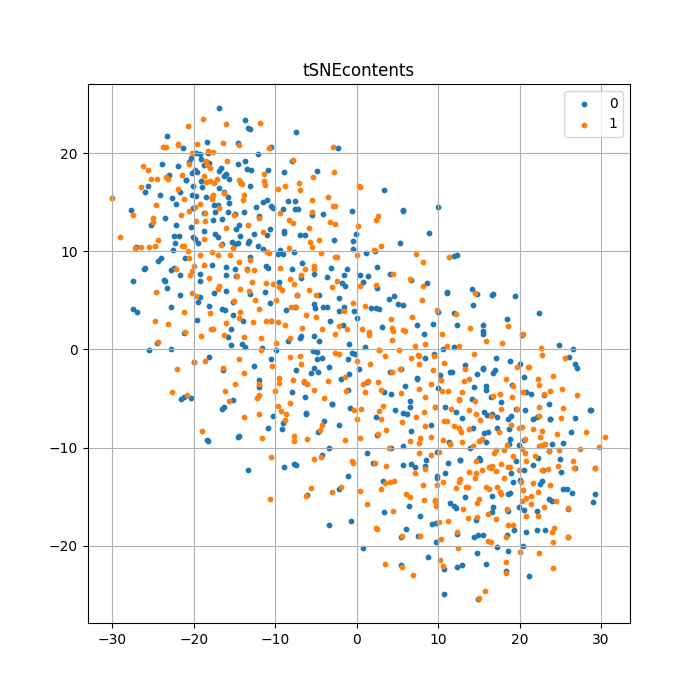

In [68]:
Image.open(contents_plot)

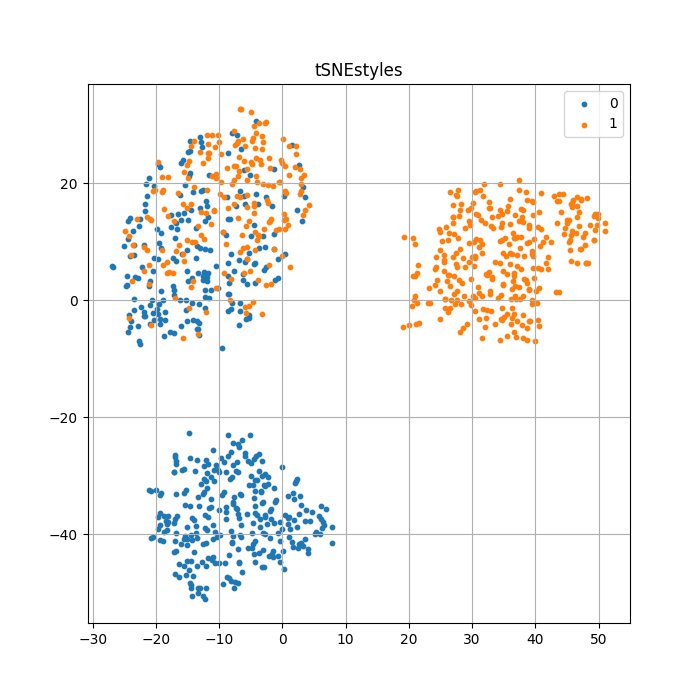

In [69]:
Image.open(styles_plot)

In [41]:
from utils import infer_mask
import torch
model = model.to('cpu')
device = 'cpu'
ae_model = model.autoencoder
style = negative
max_sentence_length = 50


# texts = real_negative_texts
# lens = np.array([len(text) for text in texts])
# texts = texts[lens < 50]
# texts = texts[np.random.randint(0, len(texts), 100)]
# texts = ['жизнь теряет смысл . я не чувствую себя лучше .', 
#          'самые большие пробки в академ - в субботу .', 
#         'охуенное было время',
#          'такое новогоднее настроение , если честно )']

texts = train_texts[:10]

ids, embs = text_handler.get_embeddings(texts, max_sentence_length=max_sentence_length)
mask = infer_mask(ids, text_handler.get_pad_id_symbol()) 

if style is not None:
    style = torch.tensor(style).type(torch.FloatTensor).to(device)

    if len(style.shape) == 1:
        style = style[None, :].repeat(len(texts), 1).to(device)

real_style, content = ae_model.encoder(embs, mask)

if style is None:
    style = real_style

latent_vector = torch.cat([style, content], dim=1)
batch_size = ids.shape[0]
state = torch.zeros(batch_size, 256-latent_vector.shape[1], device=device)
state = torch.cat([state, latent_vector], dim=1)
T = embs.shape[1]
out_ids = []

prev_token_embs = torch.zeros_like(embs[:, 0])
for i in range(T):
    input_gru = torch.cat([prev_token_embs, latent_vector], dim=1)
    state = ae_model.decoder.gru(input_gru, state)
    log_probs = ae_model.decoder.log_softmax(ae_model.decoder.out(state))
    ids = log_probs.argmax(axis=1)
    prev_token_embs = text_handler.embeddings[ids]
    out_ids.append(ids.cpu().numpy())
out_ids = np.array(out_ids).T

In [42]:
for i in range(len(texts)):
    print(texts[i])
    print(text_handler.transform_ids_to_str(out_ids)[i])
    print()

– «да ты чей?» – «я сирота – нет у меня ни отца, ни матери».
– « да сколько ты сирота мужик у меня мужика, ни у меня ни мало рублеи ».

столкновения на индо-пакистанской границе возобновились сентября.
наехали - девицы, старик - девицыи солдат ночь ночевал.

сулеймани взял командование в свои руки и перебросил в багдад своих лучших бойцов.
илья приказал свою дочь взял в руки, а в своих государстве дал ему взял : взял меня в кучу денег.

теперь мы впали в другую крайность.
теперь мы в другои воды, глядь.

вот увидал я там, что скотина дешева, только комары да мухи дороги, взял и слез на землю, наловил я мух и комарей два куля, взвалил их на спину и вскарабкался опять на небо.
вот увидал те, что вода уж солдат, дая самого вся скотина, вскочил туда, вскочил туда, вскочил их на полатил и зажегл плетек, чтоб они потроха на полати

стоп-кадр: как бирхофф фогтса отблагодарил
– закричал - как : бывало, поимал тебя потихонечку : отбил себе припев

крестьянский сын снял с себя пояс и с шеи шелко

'хочу домой ) на фотографии высмотрила свой балкон'

In [9]:
import numpy as np
mask_texts = np.array([len(text) for text in train_texts]) < 50

In [334]:
train_texts[mask_texts][:20]

array(['не ну ваще вся машина под коркой льда )',
       'какой гэри тут однако охохо челочка',
       'ну хорошо ) на недели уже отправлю )',
       'такое новогоднее настроение , если честно )',
       'сегодня все в ожидании чуда от d & amp',
       'жизнь теряет смысл . я не чувствую вкус пива .',
       'долгие и затянутые перестрелки там', 'в гуме новогодняя сказка )',
       'вас там держали долго ?( сочувствую',
       'а делать то больше нечего (', 'меня вообще нет (',
       'ахахахаха обожаю тебя ! вот че ты такой умница )',
       'травка дает о себе знать (',
       'ну епрст , я так хотела , чтобы наргиз победила',
       'а вот и буду я же дерзкий и не слушаюсь !',
       'а так и не посмотрела новогодние фильмы . (',
       'жаль что это редкость (',
       'линта , я поехала на хор на другой конец города',
       'атлетико помогает зениту всем , чем может',
       'у тебя что - то с дикцией ксюнь'], dtype='<U209')

In [164]:
from utils import infer_mask
ae_model = model.autoencoder
style = None
max_sentence_length = 50

texts = train_texts[train_labels == 1][:10]

ids, embs = text_handler.get_embeddings(texts, max_sentence_length=max_sentence_length)
mask = infer_mask(ids, text_handler.get_pad_id_symbol()) 

if style is not None:
    style = torch.tensor(style).type(torch.FloatTensor).to(device)

    if len(style.shape) == 1:
        style = style[None, :].repeat(len(texts), 1).to(device)

style, content = ae_model.encoder(embs, mask)

T = embs.shape[1]
latent_vector = torch.cat([style, content], dim=1)
batch_size = embs.shape[0]
state = latent_vector

out_ids = []

prev_token_embs = torch.zeros_like(embs[:, 0])
for i in range(T):
    state = ae_model.decoder.gru(prev_token_embs, state)
    probs = ae_model.decoder.log_softmax(ae_model.decoder.out(state))
    ids = probs.argmax(axis=1)
    prev_token_embs = text_handler.embeddings[ids]
    out_ids.append(ids.cpu().numpy())
    
out_ids = np.array(out_ids).T

RuntimeError: input has inconsistent input_size: got 768, expected 904

In [186]:
train_texts[train_labels == 1][:10]

array(['не ну ваще вся машина под коркой льда )',
       'люблю слушать песни которым уже несколько лет . пускай они уже не популярны , но по - моему они гараздо лучше большинства новых песен . цени .',
       'это неплохой пример , а представь тоже самое , но надо еще города и дороги строить',
       'странная работа смм : если проблемы со связью , то обязательно у нас',
       'какой гэри тут однако охохо челочка',
       'для меня это было бы очень серьезной проблемой ) а пока я тихо хлюпаю носом , в ый раз слыша майли сайрус .',
       'ну хорошо ) на недели уже отправлю )',
       'я просто пошла записывать фильмы и тут понеслась )',
       'комбат батяня , батяня комбат , ты сердце не прятал за спины ребят .',
       'такое новогоднее настроение , если честно )'], dtype='<U209')

In [189]:
text_handler.transform_ids_to_str(out_ids)

['не ну ваще вся машина под коркои замерз )',
 'люблю слушать музыку нам ушли не были до конца, а мы на сцене, не они. нихуярятся наргиз в них! бляют.',
 'это неплохои пример, а представь тоже самое, просто везде, два раза из - се',
 'странная работа дает фото - если занята свои вещи, я сама им с',
 'какои гэри тут явно охилоо фотка',
 'для меня это было простое стало привычно и сижу ) я смотрю ну ибо спать с тобои, а потом в первы сидираю сходить',
 'ну хорошо ) уже дня на физику отправ )',
 'я просто пошла записывать фильмы и тут понеслась )',
 'комбат батяня, батянят би, мечты, что меня под винил! ну',
 'такое новогоднее настроение, если честно )']

In [152]:
text_handler.transform_ids_to_str(out_ids)

['не ну ваще жизнь замерз под елкои снег )',
 'люблю слушать музыку нам уже игры. еще до питеры. не только лаиков. - они очень любят снежинок слэша по сравнению. п!',
 'это неплохои пример, а представь тоже самое, просто везде ) еще два из весны',
 'странная работа смм, проблемы забываю свои ) но то мои и',
 'какои гэри тут наоборот ааадньки',
 'для меня это было бы очень ) рыло начиналось и я думаю спокоино ) я думаю что спил, теперь и первыи сваливаю потом в',
 'ну хорошо ) уже недели на физику отправ )',
 'я просто пошла записывать танец и тут понеслась )',
 'комбат батяня, батянят боб, надеюсь это планы поиду и со! обидно',
 'такое новогоднее настроение, если честно )']

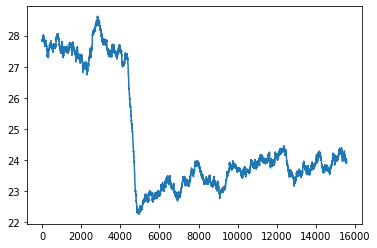

In [159]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

iter_logs_path = os.path.join(run_path, 'logs', 'iter_logs.csv')
epoch_logs_path = os.path.join(run_path, 'logs', 'epoch_logs.csv')
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

ae_loss = np.array(pd.read_csv(iter_logs_path).ae_loss)
plt.plot(moving_average(ae_loss, n=500)[40000:])
ae_loss = np.array(pd.read_csv(epoch_logs_path).val_ae_loss)
#plt.plot(range(10000, 360000, 11211), ae_loss)

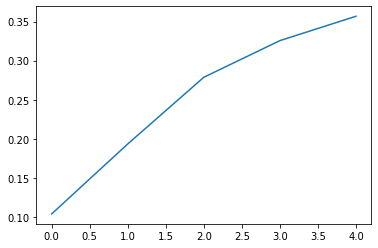

In [162]:
plt.plot(pd.read_csv(epoch_logs_path).bleu)

In [157]:
ae_loss

array([60.55077448, 45.70074931, 37.05775223, 33.23017952, 31.47249638])

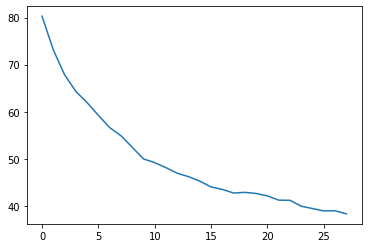

In [183]:
plt.plot(moving_average(ae_loss, n=5))

In [167]:
len(range(10000, 360000, 11211))

32

In [11]:
train_csv_path = os.path.join(data_path, 'train.csv')
val_csv_path = os.path.join(data_path, 'val.csv')

In [6]:
from data_handler import get_texts_and_labels

In [7]:
train_texts, train_labels = get_texts_and_labels(train_csv_path)

In [18]:
train_texts, train_labels

(array(['– «да ты чей?» – «я сирота – нет у меня ни отца, ни матери».',
        'столкновения на индо-пакистанской границе возобновились сентября.',
        'сулеймани взял командование в свои руки и перебросил в багдад своих лучших бойцов.',
        ...,
        'много ли аршин?» – «да я в квасу хлеба накрошила густо-нагусто, и с лучком и с маслицем!»\n\n\n\n\n\n* * *\n\n\nу одной бабы был муж глухой.',
        'в пятницу экс-президента похоронят на национальном кладбище на горе герцля в иерусалиме.',
        '(на % больше, чем в г.'], dtype='<U1298'),
 array([0, 1, 1, ..., 0, 1, 1]))

In [88]:
train_texts[[text.find('большие пробк') != -1 for text in train_texts]]

array(['самые большие пробки в академ - в субботу .'], dtype='<U209')

In [7]:
texts[labels == 1]

NameError: name 'texts' is not defined

In [94]:
pd.read_csv(epoch_logs_path).val_ae_loss

0    99.921192
1    85.828181
2    77.986935
3    71.323523
4    66.272404
5    64.239056
6    59.413238
7    60.367387
Name: val_ae_loss, dtype: float64

In [12]:
train_csv_id = '1T9MLSLIIAfslcT_Od6CgEWPZg3hr70RY'
val_csv_id = '11GXyAhbE4jyW1DSnfXss5WcCOJE_xQ_H'
train_csv_path = os.path.join(data_path, 'train.csv')
val_csv_path = os.path.join(data_path, 'val.csv')

In [31]:
from utils import get_gdrive_wget_command

for csv_id, path in [(train_csv_id, train_csv_path), (val_csv_id, val_csv_path)]:
    wget_command = get_gdrive_wget_command(file_id=csv_id, save_to_path=path)
    result_command = os.system(wget_command)
    print('Command\n', wget_command, '\nreturned', result_command)

Command
 wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1T9MLSLIIAfslcT_Od6CgEWPZg3hr70RY' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1T9MLSLIIAfslcT_Od6CgEWPZg3hr70RY" -O /data/szgodzhaev/train.csv && rm -rf /tmp/cookies.txt 
returned 0
Command
 wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=11GXyAhbE4jyW1DSnfXss5WcCOJE_xQ_H' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=11GXyAhbE4jyW1DSnfXss5WcCOJE_xQ_H" -O /data/szgodzhaev/val.csv && rm -rf /tmp/cookies.txt 
returned 0
